# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Calibrate
4. **Calculate lattice vectors**
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 4: Calculate lattice vectors

In this step the lattice vectors are calculated from the list of Bragg peaks, as follows:

* Take the radon transform of the deconvolution
* At each angle, get a score indicating how likely this angle is a lattice direction
* Find two, non-colinear angles maximizing the score
* From these angles and the radon projections, get the corresponding vector lengths

### Import packages, load data

In [12]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import radon

from py4DSTEM.file.datastructure import PointList
from py4DSTEM.file.readwrite import FileBrowser, read, append

from py4DSTEM.process.latticevectors import get_radon_scores, get_lattice_directions_from_scores, get_lattice_vector_lengths

In [7]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    deconvolution_1                     DiffractionSlice    
   3    deconvolution_shiftcorrected        DiffractionSlice    
   4    deconvolution_shiftcorrected_ellipsecorrectedDiffractionSlice    
   5    deconvolution_uncorrected           DiffractionSlice    
   6    diffractionslice_3                  DiffractionSlice    
   7    probe_kernel                        DiffractionSlice    
   8    DF_image                            RealSlice           
   9    DF_image_1                          RealSlice           
   10   diffraction_shifts                  RealSlice           
   11   diffraction_shifts_1                RealSlice           
   12   diffraction_shifts_2                RealSlice           
   13   realslice_0                         RealSlice           
   14   strain_m

In [8]:
# Load data

dc = browser.get_dataobject('datacube')
Bragg_peaks = browser.get_dataobject('shifted_Braggpeaks')
deconvolution = browser.get_dataobject('deconvolution').data2D
browser.close()

### Take radon transform of average deconvolution

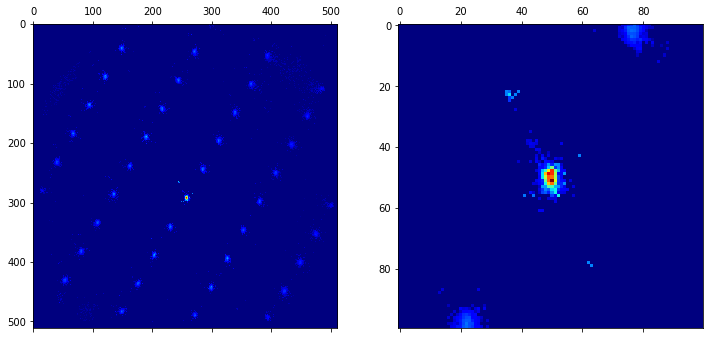

In [9]:
# Show deconvolution

power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(deconvolution**power,cmap='jet')
ax2.matshow(deconvolution[x0-50:x0+50,y0-50:y0+50]**power,cmap='jet')
plt.show()

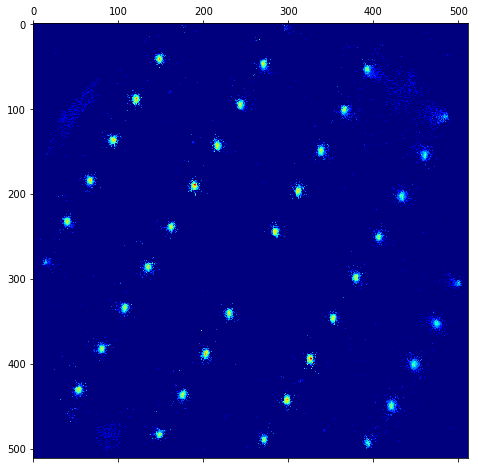

In [10]:
# Get mask for unscattered beam

maskrad = 40
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
ry,rx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
mask = ((rx-x0)**2+(ry-y0)**2) > maskrad**2

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((deconvolution*mask)**power,cmap='jet')
plt.show()

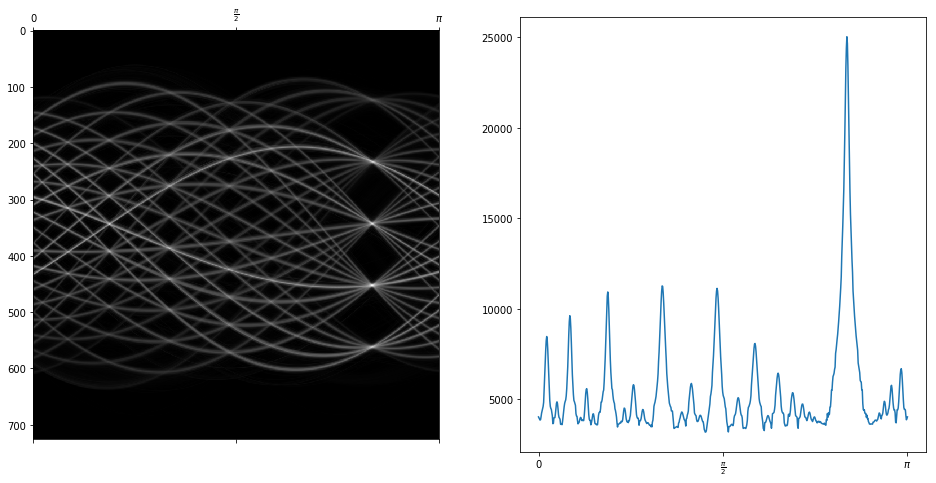

In [15]:
# Get scores

N_angles = 720
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05

power = 0.5

scores, thetas, sinogram = get_radon_scores(deconvolution, mask, N_angles, sigma, minSpacing, minRelativeIntensity)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

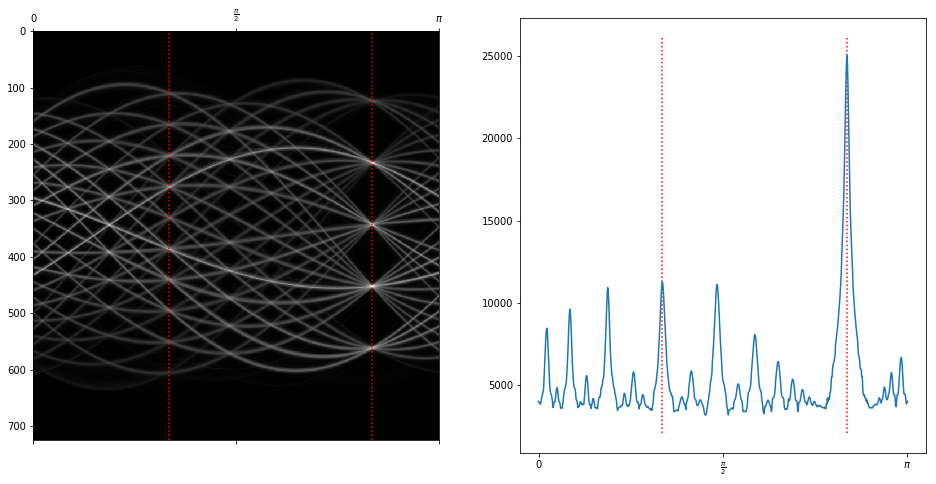

Initial guess at u and v angles is 150.5 and 60.33, respectively.


In [16]:
# Get lattice directions

sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05
index1 = 0
index2 = 0

power = 0.5

u_theta, v_theta = get_lattice_directions_from_scores(thetas, scores, sigma, minSpacing, minRelativeIntensity,
                                                                                         index1, index2)

u_theta_ind = np.argmin(np.abs(thetas-u_theta))
v_theta_ind = np.argmin(np.abs(thetas-v_theta))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.vlines((u_theta_ind,v_theta_ind),ax1.get_ylim()[0],ax1.get_ylim()[1],linestyle=":",color='r')
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.vlines((u_theta,v_theta),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyle=":",color='r')
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

print("Initial guess at u and v angles is {:.4} and {:.4}, respectively.".format(np.degrees(u_theta),np.degrees(v_theta)))

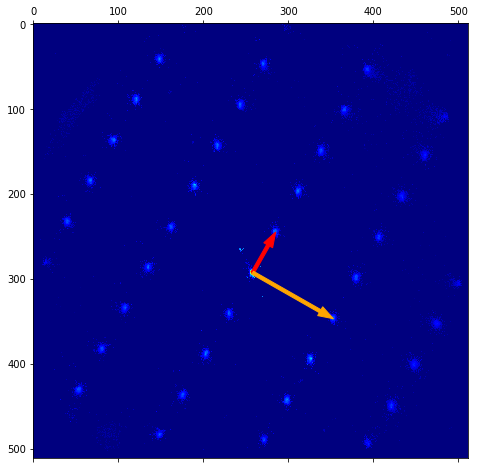

In [18]:
# Get lattice vector lengths

spacing_thresh = 1.5
sigma = 2
minSpacing = 2
minRelativeIntensity = 0.1

power = 0.25

u_length, v_length = get_lattice_vector_lengths(u_theta, v_theta, thetas, sinogram,
                                                spacing_thresh, sigma, minSpacing, minRelativeIntensity)

# Show
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
u_dx = np.sin(u_theta)*u_length
u_dy = np.cos(u_theta)*u_length
v_dx = np.sin(v_theta)*v_length
v_dy = np.cos(v_theta)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution**power,cmap='jet')
ax.arrow(y0,x0,u_dx,u_dy, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,v_dx,v_dy, color='orange',width=4,length_includes_head=True)
plt.show()

In [6]:
# Take Radon transform

N_thetas = 720
thetas = np.linspace(0,180,N_thetas)

sinogram = radon(deconvolution_beamstopped, theta=thetas, circle=False)

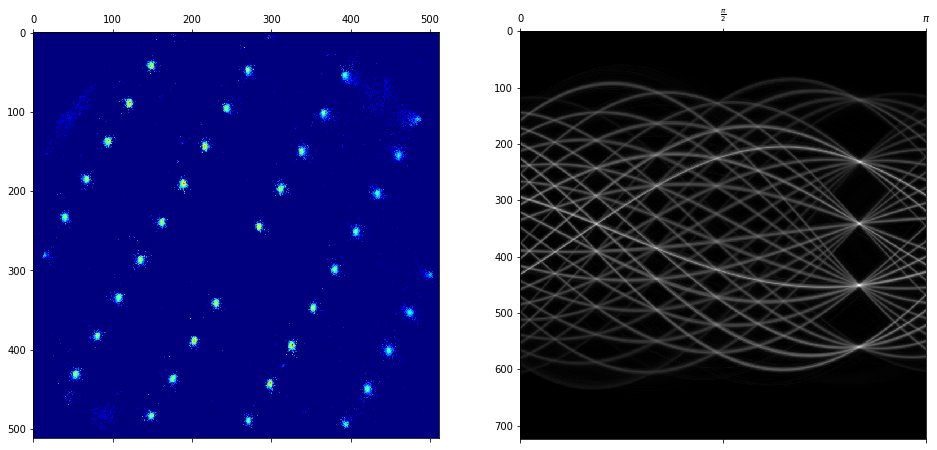

In [7]:
# Show

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution_beamstopped**power,cmap='jet')
ax2.matshow(sinogram**0.5)
ax2.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax1.grid(False)
ax2.grid(False)
plt.show()

### For all angles, find maxima of Radon transform slice

In [8]:
# As a function of rotation angle, find number and intensity of histogram maxima

min_dist = 10
sigma = 2
threshhold = 0.05

# Metrics
N_maxima = np.empty_like(thetas)
total_intensity = np.empty_like(thetas)

for j in range(len(thetas)):
    theta = thetas[j]
    
    # Get slice through radon transform at theta
    ind = np.argmin(np.abs(thetas-theta))
    sinogram_theta = sinogram[:,ind]
    sinogram_theta = gaussian_filter(sinogram_theta,sigma)
    
    # Get maxima
    maxima0 = (sinogram_theta > np.roll(sinogram_theta,-1)) & (sinogram_theta >= np.roll(sinogram_theta,+1))
    
    coordinates = [('r',int),('intensity',float)]
    maxima = PointList(coordinates)
    for i in maxima0.nonzero()[0]:
        new_point = (i, sinogram_theta[i])
        maxima.add_point(new_point)
    maxima.sort('intensity')

    # Remove maxima which are too close together
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if not deletemask[i]:
            delete = np.abs(maxima.data['r'][i]-maxima.data['r']) < min_dist
            delete[:i+1]=False
            deletemask = deletemask | delete
    maxima.remove_points(deletemask)

    # Remove maxima below threshhold
    max_intensity = maxima.data['intensity'][0]
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if maxima.data['intensity'][i]/max_intensity < threshhold:
            deletemask[i] = True
    maxima.remove_points(deletemask)
        
    # Calculat metrics
    N_maxima[j] = maxima.length
    total_intensity[j] = np.sum(maxima.data['intensity'])

### Get guess at u and v angles

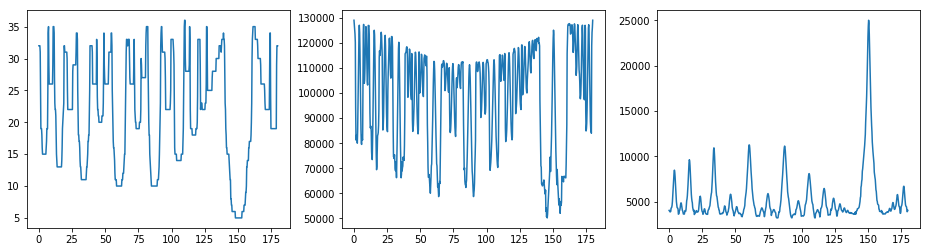

In [9]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

score = total_intensity/N_maxima

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.plot(thetas,N_maxima)
ax2.plot(thetas,total_intensity)
ax3.plot(thetas,score)
plt.show()

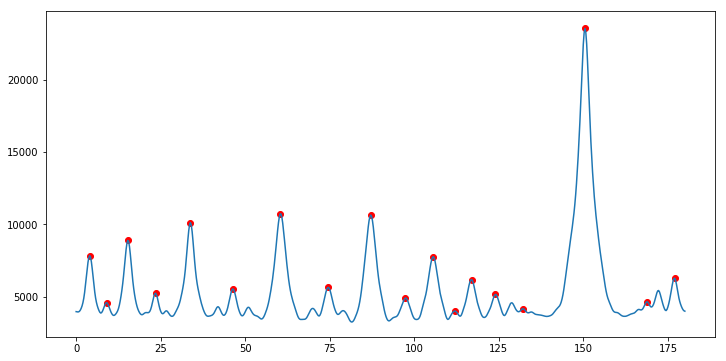

In [10]:
# Get maxima of scores

sigma = 2
min_diff = 5

score_blurred = gaussian_filter(score,sigma)

score_maxima0 = (score_blurred > np.roll(score_blurred,-1)) & (score_blurred >= np.roll(score_blurred,+1))

coordinates = [('theta',float),('intensity',float)]
score_maxima = PointList(coordinates)

for i in score_maxima0.nonzero()[0]:
    new_point = (thetas[i], score_blurred[i])
    score_maxima.add_point(new_point)
score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['theta'][i]-score_maxima.data['theta']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)


# Plot score and maxima

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(thetas, score_blurred)
ax.scatter(score_maxima.data['theta'],score_maxima.data['intensity'],color='r')
plt.show()

In [11]:
# Get initial guess at u angle

score_maxima.sort('intensity')
u_theta = score_maxima.data['theta'][0]

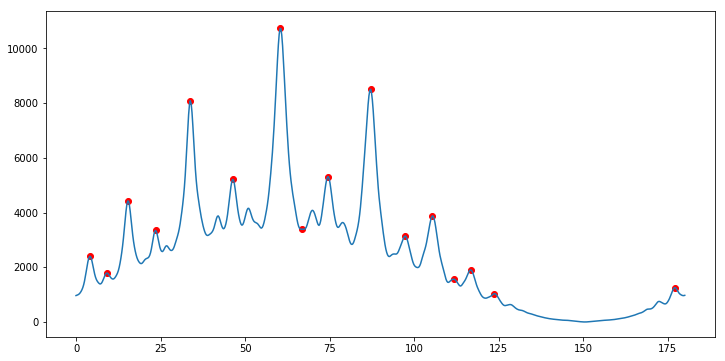

In [12]:
# Damp scores by cosine envelope about the u angle
# Get maxima, plot

sigma = 2
min_diff = 5

score_sin_damped = score_blurred*np.sin((thetas-u_theta)*np.pi/180.)**2

score_maxima0 = (score_sin_damped > np.roll(score_sin_damped,-1)) & (score_sin_damped >= np.roll(score_sin_damped,+1))

coordinates = [('theta',float),('intensity',float)]
score_maxima = PointList(coordinates)

for i in score_maxima0.nonzero()[0]:
    new_point = (thetas[i], score_sin_damped[i])
    score_maxima.add_point(new_point)
score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['theta'][i]-score_maxima.data['theta']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(thetas, score_sin_damped)
ax.scatter(score_maxima.data['theta'],score_maxima.data['intensity'],color='r')
plt.show()

In [13]:
# Get guess at v angle

score_maxima.sort('intensity')
v_theta = score_maxima.data['theta'][0]

In [14]:
print("Initial guess at u and v angles is {} and {}, respectively.".format(u_theta,v_theta))

Initial guess at u and v angles is 150.45897079276773 and 60.333796940194716, respectively.


### Get lattice vector lengths

In [15]:
# Parameters

sigma = 2
min_dist = 10
threshhold = 0.05

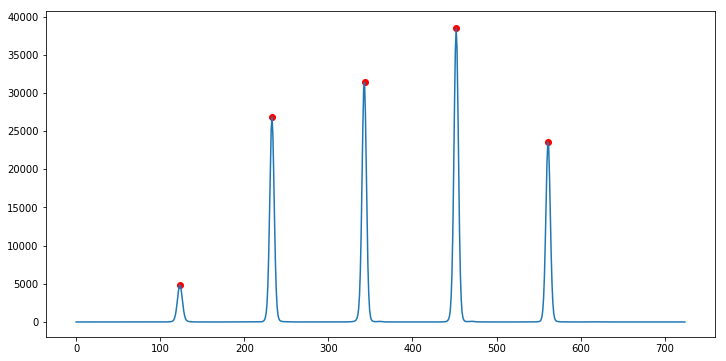

In [16]:
# Find maxima when projected down u

theta = u_theta

# Get slice through radon transform at theta
ind = np.argmin(np.abs(thetas-theta))
sinogram_theta = sinogram[:,ind]
sinogram_theta = gaussian_filter(sinogram_theta,sigma)

# Get maxima
maxima0 = (sinogram_theta > np.roll(sinogram_theta,-1)) & (sinogram_theta >= np.roll(sinogram_theta,+1))

coordinates = [('r',int),('intensity',float)]
maxima = PointList(coordinates)
for i in maxima0.nonzero()[0]:
    new_point = (i, sinogram_theta[i])
    maxima.add_point(new_point)
maxima.sort('intensity')

# Remove maxima which are too close together
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if not deletemask[i]:
        delete = np.abs(maxima.data['r'][i]-maxima.data['r']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
maxima.remove_points(deletemask)

# Remove maxima below threshhold
max_intensity = maxima.data['intensity'][0]
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(sinogram_theta.shape[0]), sinogram_theta)
ax.scatter(maxima.data['r'],maxima.data['intensity'],color='r')
plt.show()

In [17]:
# Get u projected spacing

thresh=1.5

maxima.sort('r')
diffs = maxima.data['r'][:-1]-maxima.data['r'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
u_projected_spacing = np.average(diffs)

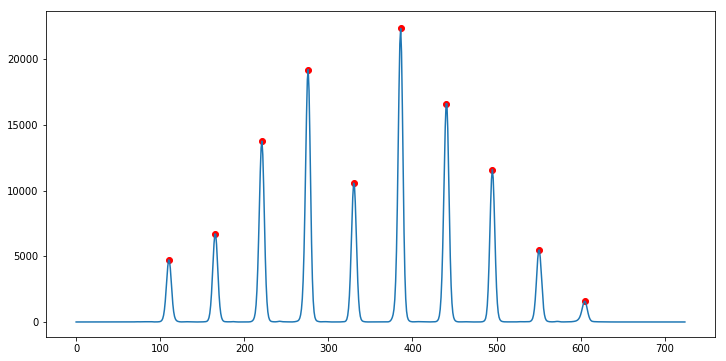

In [18]:
# Find maxima when projected down v

theta = v_theta

# Get slice through radon transform at theta
ind = np.argmin(np.abs(thetas-theta))
sinogram_theta = sinogram[:,ind]
sinogram_theta = gaussian_filter(sinogram_theta,sigma)

# Get maxima
maxima0 = (sinogram_theta > np.roll(sinogram_theta,-1)) & (sinogram_theta >= np.roll(sinogram_theta,+1))

coordinates = [('r',int),('intensity',float)]
maxima = PointList(coordinates)
for i in maxima0.nonzero()[0]:
    new_point = (i, sinogram_theta[i])
    maxima.add_point(new_point)
maxima.sort('intensity')

# Remove maxima which are too close together
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if not deletemask[i]:
        delete = np.abs(maxima.data['r'][i]-maxima.data['r']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
maxima.remove_points(deletemask)

# Remove maxima below threshhold
max_intensity = maxima.data['intensity'][0]
deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(sinogram_theta.shape[0]), sinogram_theta)
ax.scatter(maxima.data['r'],maxima.data['intensity'],color='r')
plt.show()

In [19]:
# Get v projected spacing

thresh=1.5

maxima.sort('r')
diffs = maxima.data['r'][:-1]-maxima.data['r'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
v_projected_spacing = np.average(diffs)

In [20]:
# Get u and v lengths

sin_uv = np.sin(np.abs(u_theta-v_theta)*np.pi/180.)
u_length = v_projected_spacing / sin_uv
v_length = u_projected_spacing / sin_uv

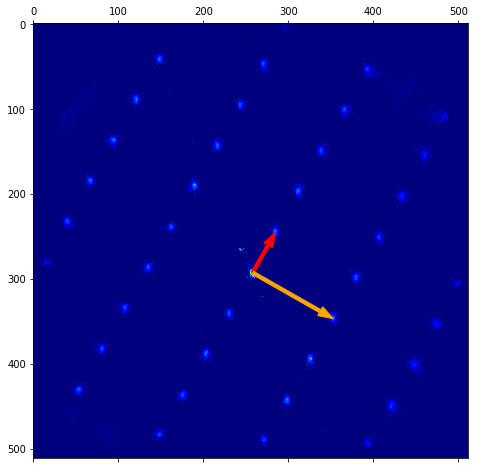

In [21]:
# Show

power = 0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

u_dx = np.sin(u_theta*np.pi/180.)*u_length
u_dy = np.cos(u_theta*np.pi/180.)*u_length
v_dx = np.sin(v_theta*np.pi/180.)*v_length
v_dy = np.cos(v_theta*np.pi/180.)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution.data2D**power,cmap='jet')
ax.arrow(y0,x0,u_dx,u_dy, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,v_dx,v_dy, color='orange',width=4,length_includes_head=True)
plt.show()

### Save lattice vectors

In [22]:
# Make pointlist

coordinates = [('angle',float),('length',float)]
lattice_vectors = PointList(coordinates, name='lattice_vectors')
lattice_vectors.add_point((u_theta,u_length))
lattice_vectors.add_point((v_theta,v_length))

In [23]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(lattice_vectors, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
